# Exponential-family EKF

$$
\begin{aligned}
    p(\theta_t \vert \theta_{t-1}) &= {\cal N}(\theta_t \vert \theta_{t-1}, Q_t)\\
    p(y_t \vert \theta_{t}, {\bf x}_t) &= \text{expfam}(y_t \vert h(\theta_t, {\bf x}_t))\\
\end{aligned}
$$

In [1]:
import jax
import chex
import einops
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from jax.flatten_util import ravel_pytree

In [2]:
%config InlineBackend.figure_format = "retina"

## Bernoulli

Log-partition is given by

$$
    A(\eta) = \log(1 + \exp(\eta))
$$

In [3]:
n_samples = 200
data = make_moons(n_samples=n_samples, random_state=314, noise=0.15)
X, y = jax.tree_map(jnp.array, data)

key = jax.random.PRNGKey(314)

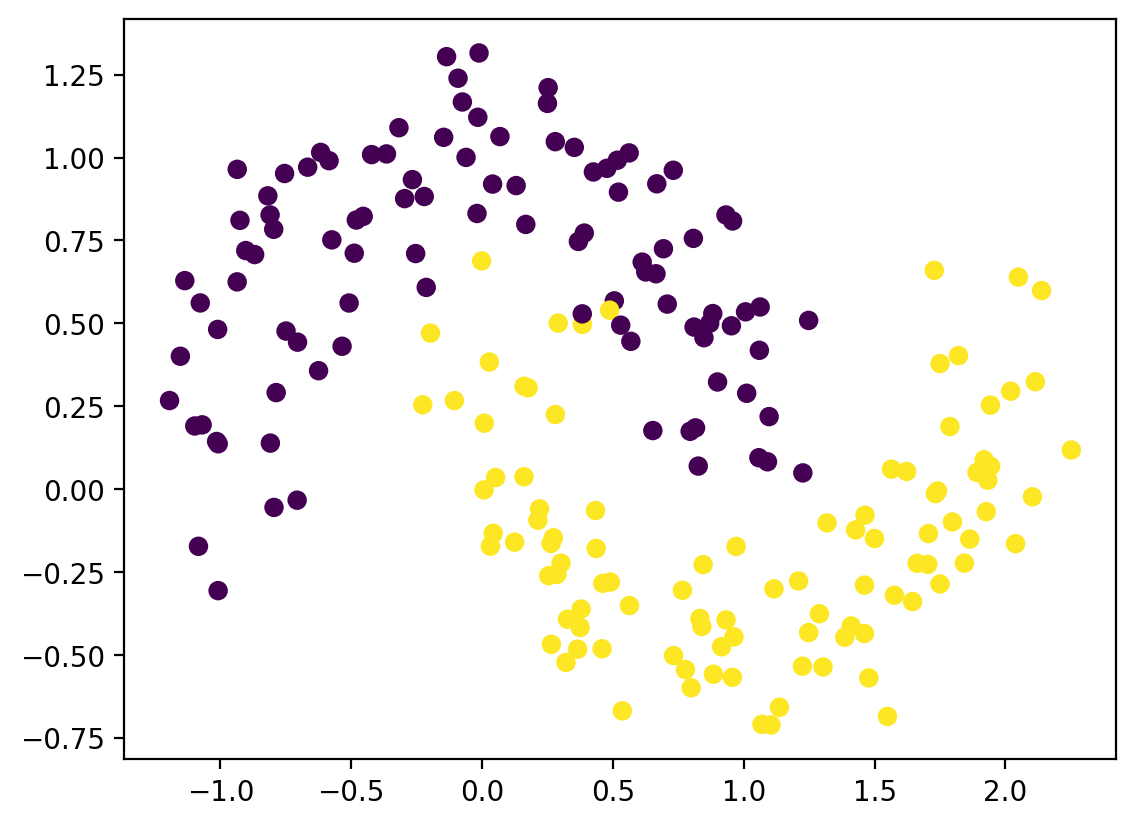

In [4]:
plt.scatter(*X.T, c=y)

In [5]:
@chex.dataclass
class Bel:
    mean: chex.Array
    cov: chex.Array

In [6]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x # Eta
    
model = MLP()
params = model.init(key, X)
params, rfn = ravel_pytree(params)
nparams = len(params)

def applyfn(params, x):
    return model.apply(rfn(params), x)

In [126]:
@jax.jit
def log_partition(eta):
    return jnp.log(1 + jnp.exp(eta)).sum()

@jax.jit
def suff_stat(y):
    return y


@jax.jit
def mean(eta):
    return jax.grad(log_partition)(eta)


@jax.jit
def covariance(eta):
    return jax.hessian(log_partition)(eta).squeeze()


@jax.jit
def linkfn(params, x):
    eta = applyfn(params, x)
    return eta

In [8]:
bel_init = Bel(
    mean=params,
    cov=jnp.eye(nparams) * 2.0
)

In [9]:
dynamics_covariance = 0.0 # TODO: Change

dmodel = jax.jacfwd(applyfn)

def step(bel, xs):
    xt, yt = xs
    pcov_pred = bel.cov + dynamics_covariance
    pmean_pred = bel.mean
    nparams = len(pmean_pred)
    I = jnp.eye(nparams)
    
    eta = linkfn(bel.mean, xt).astype(float)
    yhat = mean(eta)
    err = suff_stat(yt) - yhat
    Rt = covariance(eta)
    
    Ht = dmodel(pmean_pred, xt)
    # Kt = pcov_pred @ Ht.T @ jnp.linalg.inv(Ht @ pcov_pred @ Ht.T + Rt)
    Kt = jnp.linalg.solve(Ht @ pcov_pred @ Ht.T + Rt, Ht @ pcov_pred).T
    
    pcov = (I - Kt @ Ht) @ pcov_pred
    pmean = pmean_pred + (Kt @ err).squeeze()
    
    bel = bel.replace(mean=pmean, cov=pcov)
    return bel, bel.replace(cov=0.0) # Save memory

In [11]:
D = (X, y)
bel, bel_hist = jax.lax.scan(step, bel_init, D)

In [12]:
eta = linkfn(bel.mean, X)
yhat = jax.nn.sigmoid(eta) > 0.5

In [13]:
(y == yhat.squeeze()).mean()

Array(0.935, dtype=float32)

In [14]:
XX = np.mgrid[-1.5:2:0.05, -1.5:2:0.05]

In [15]:
Xeval = einops.rearrange(XX, "d x y -> x y d")

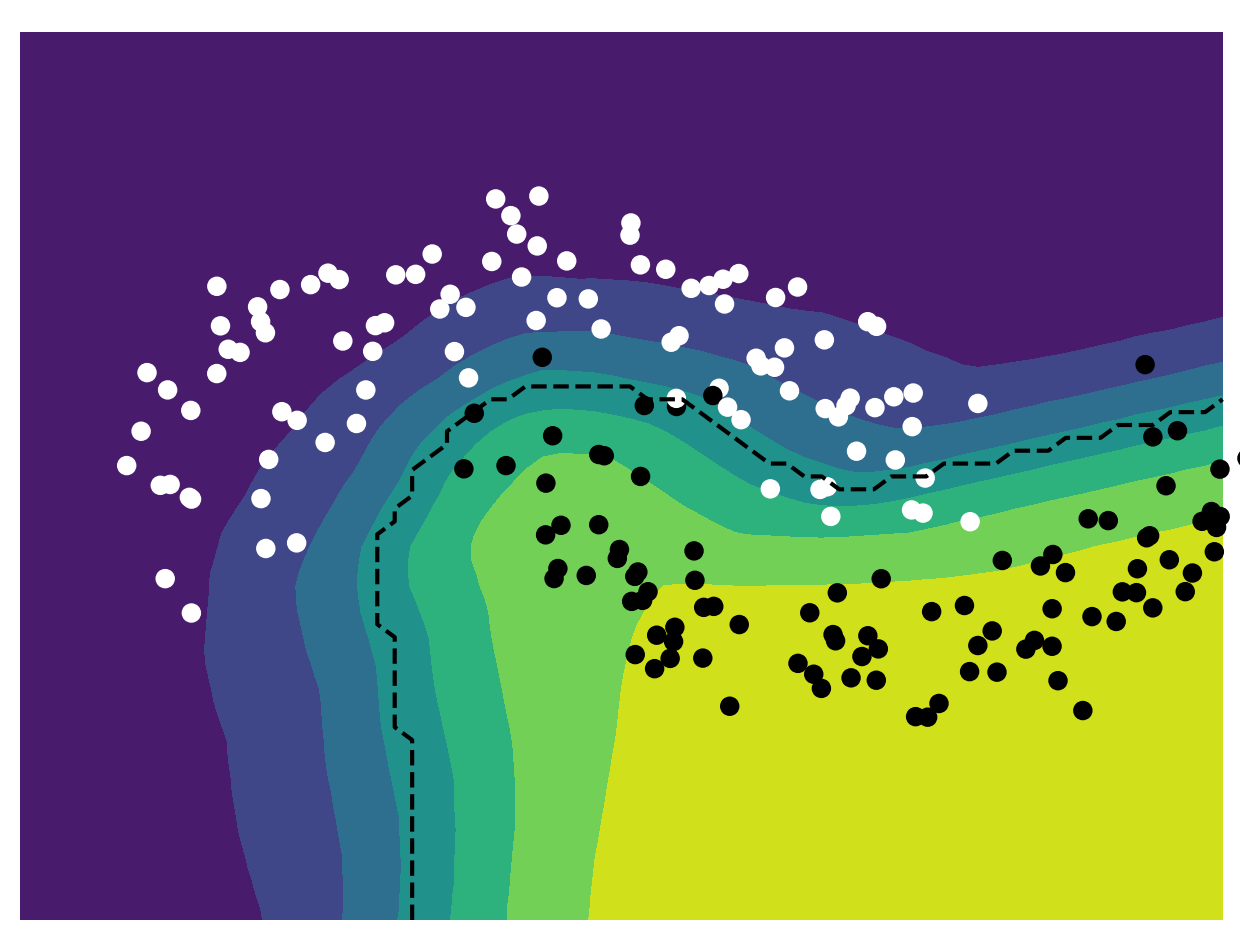

In [16]:
Z = np.array(applyfn(bel.mean, Xeval).squeeze())
plt.contourf(*XX, mean(Z))
plt.contour(*XX, mean(Z) > 0.5, colors="black", linestyles="--")
plt.scatter(*np.array(X).T, c=y, cmap="bone_r")
plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")
plt.tight_layout()

## Animating

In [958]:
import numpy as np
from matplotlib.animation import FuncAnimation

MovieWriter ffmpeg unavailable; using Pillow instead.
/tmp/ipykernel_3714514/1045232681.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


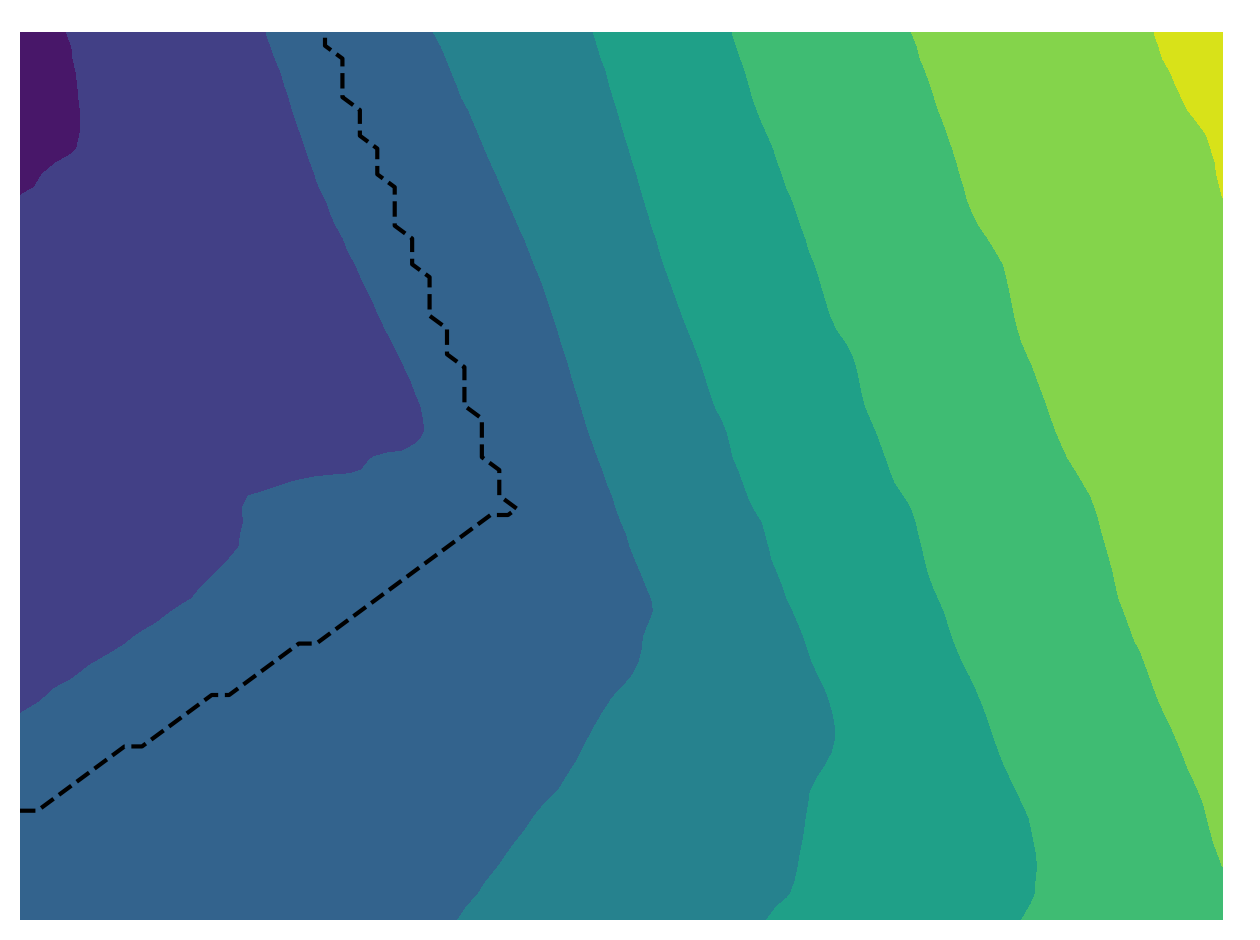

In [30]:
fig, ax = plt.subplots()

def anim(t):
    ax.cla()
    bel = jax.tree_map(lambda x: x[t], bel_hist)
    Z = np.array(applyfn(bel.mean, Xeval).squeeze())
    plt.contourf(*XX, mean(Z))
    plt.contour(*XX, mean(Z) > 0.5, colors="black", linestyles="--")
    plt.scatter(*np.array(X)[:t].T, c=y[:t], cmap="bone_r")
    plt.ylim(-1.5, 2)
    plt.xlim(-1.5, 2)
    plt.axis("off")
    plt.tight_layout()

frames = np.arange(n_samples)
animation = FuncAnimation(fig, anim, frames=frames)
animation.save("bern-ekf.gif", fps=20)

# Gaussian: Heteroskedastic

Log-partition is given by

$$
    A(\boldsymbol\eta) = A(\eta_1, \eta_2) = -\frac{\eta_1^2}{4\eta_2} - \frac{1}{2}\log(-2\eta_2)
$$

In [1347]:
def fourier_basis(domain, b_coef, include_bias=False):
    return jnp.c_[domain, domain ** 2]

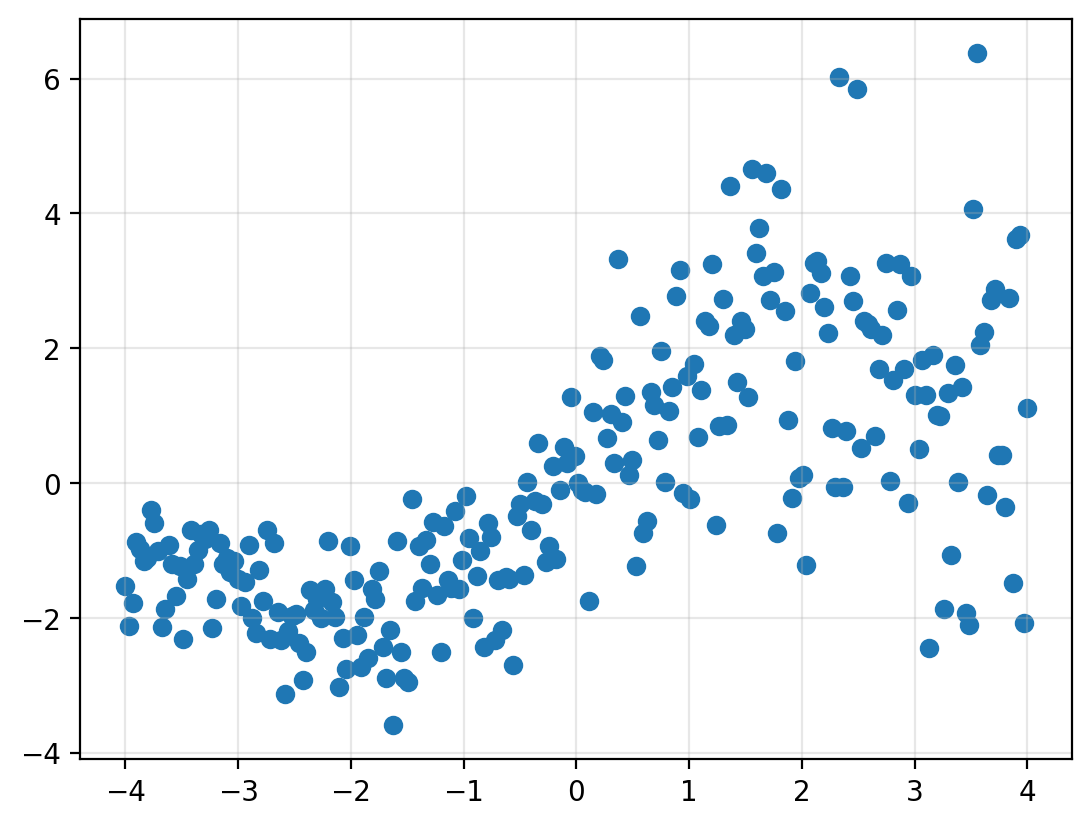

In [1361]:
key = jax.random.PRNGKey(3141)
key_data, key_train = jax.random.split(key)


n_samples = 250
key_x, key_y, key_basis = jax.random.split(key_data, 3)

key_noise, key_y = jax.random.split(key_y)
err = jax.random.normal(key_y, (n_samples,))

x = jnp.linspace(-4, 4, n_samples)

# scales = jax.random.uniform(key_noise, (n_samples,), minval=0.01, maxval=1.0)
# scales = jnp.linspace(0.01, 1.0, n_samples)
scales = np.sqrt(jnp.exp(x / 3))
err = err * scales


y_clean = 0.5 * x + jnp.sin(x)
y = y_clean + err

# ixs_new = jax.random.choice(key_x, n_samples, (n_samples,), replace=False)
# x, y = x[ixs_new], y[ixs_new]
# y_clean = y_clean[ixs_new]

num_basis, input_dim = 3, 1
b = jax.random.normal(key_basis, (num_basis, input_dim)) * 0.8
X = fourier_basis(x[:, None], b)

plt.scatter(x, y)
plt.grid(alpha=0.3)

In [1362]:
@jax.jit
def log_partition(eta):
    eta1, eta2 = eta
    return -eta1 ** 2 / (4 * eta2) - jnp.log(-2 * eta2) / 2

@jax.jit
def suff_stat(y):
    return jnp.array([y, y ** 2])

In [1363]:
eta_init = jnp.array([1.0, -1.0])
covariance(eta_init)

Array([[0.5, 0.5],
       [0.5, 1. ]], dtype=float32)

In [1375]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(30)(x)
        x = nn.relu(x)
        x = nn.Dense(30)(x)
        x = nn.relu(x)
        x = nn.Dense(30)(x)
        x = nn.relu(x)


        x = nn.Dense(2)(x)
        eta1, eta2 = x[..., 0], x[..., 1]
        eta = jnp.array([eta1, -jnp.exp(eta2)])
        return eta
    
model = MLP()
params = model.init(key_train, X)
params, rfn = ravel_pytree(params)
nparams = len(params)

def applyfn(params, x):
    return model.apply(rfn(params), x)

# params = jax.random.normal(key_train, (nparams,)) * 1e-2
bel_init = Bel(
    mean=params,
    cov=jnp.eye(nparams) * 5e-3
)

In [1385]:
%%time

dynamics_covariance = 0.0
D = (X, y)
bel, bel_hist = jax.lax.scan(step, bel_init, D)

xeval = jnp.linspace(-5, 4, 200)
Xeval = fourier_basis(xeval[:, None], b)
eta_eval = linkfn(bel.mean, Xeval)
preds_eval = jax.vmap(mean, 1)(eta_eval)
preds_eval = jax.tree_map(np.array, preds_eval)

CPU times: user 9.82 ms, sys: 830 µs, total: 10.6 ms
Wall time: 223 ms


In [1386]:
mean_eval = preds_eval[:, 0]
std_eval = jnp.sqrt(preds_eval[:, 1])

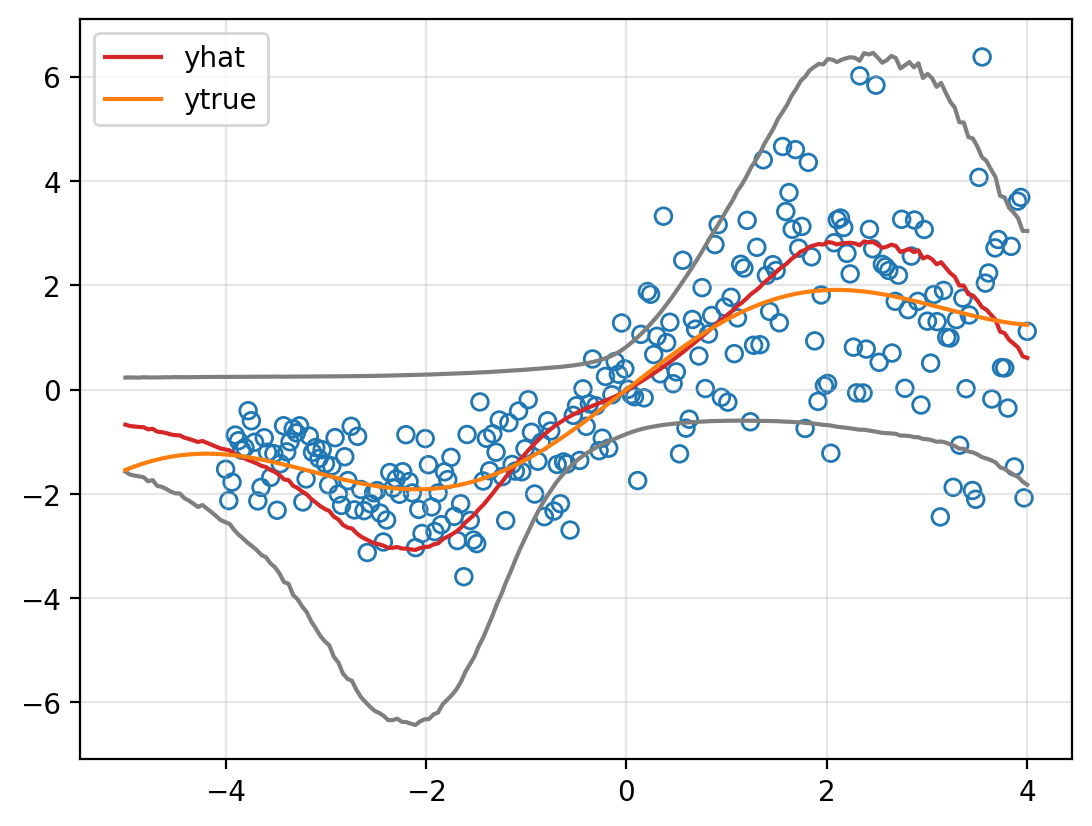

In [1387]:
plt.plot(np.array(xeval), mean_eval + std_eval, c="tab:gray")
plt.plot(np.array(xeval), mean_eval - std_eval, c="tab:gray")

plt.plot(xeval, mean_eval, c="tab:red", label="yhat")
plt.plot(xeval, xeval / 2 + jnp.sin(xeval), c="tab:orange", label="ytrue")
plt.scatter(x, y, edgecolor="tab:blue", color="none")
plt.legend()
plt.grid(alpha=0.3)

In [1388]:
eta = linkfn(bel.mean, X)
preds = jax.vmap(mean, 1)(eta)

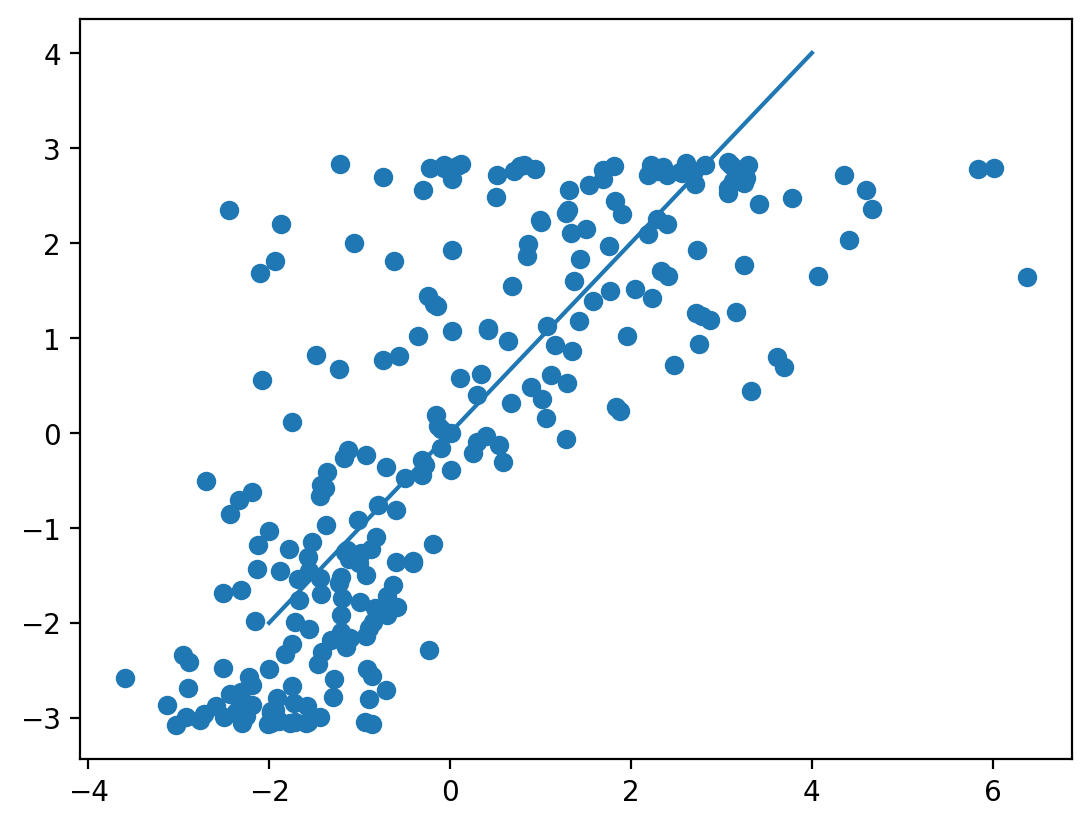

In [1389]:
plt.scatter(y, preds[:, 0])
plt.plot([-2, 4], [-2,4])

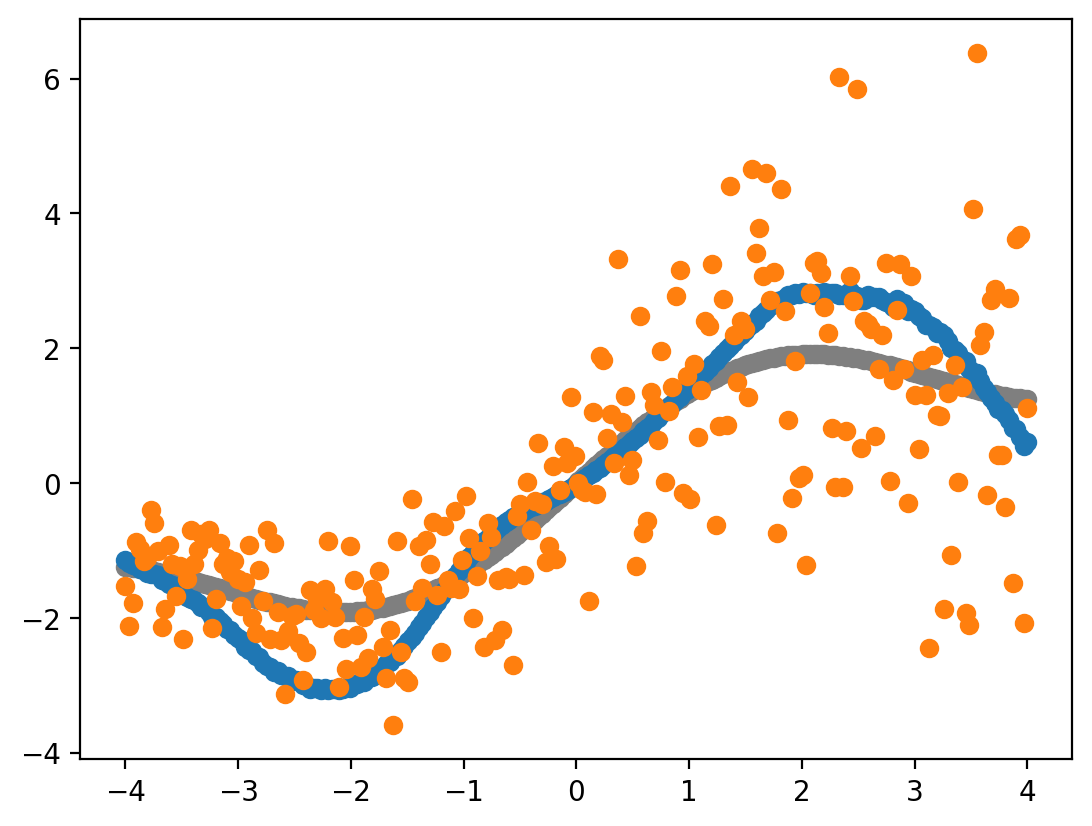

In [1390]:
plt.scatter(x, y_clean, c="tab:gray")
plt.scatter(x, preds[:, 0])
plt.scatter(x, y)

## Animating

MovieWriter ffmpeg unavailable; using Pillow instead.


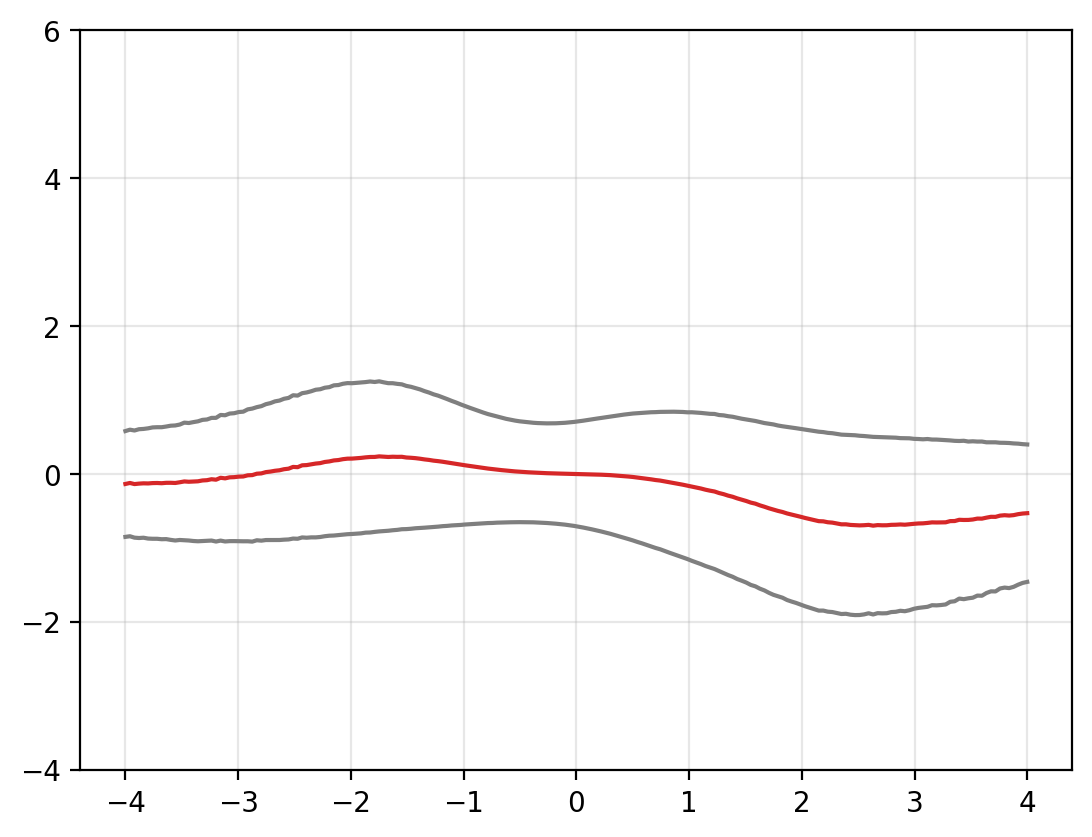

In [1227]:
fig, ax = plt.subplots()

def anim(t):
    ax.cla()
    bel = jax.tree_map(lambda x: x[t], bel_hist)
    eta_eval = linkfn(bel.mean, Xeval)
    preds_eval = jax.vmap(mean, 1)(eta_eval)
    preds_eval = jax.tree_map(np.array, preds_eval)

    mean_eval = preds_eval[:, 0]
    std_eval = jnp.sqrt(preds_eval[:, 1])

    plt.plot(np.array(xeval), mean_eval + std_eval, c="tab:gray")
    plt.plot(np.array(xeval), mean_eval - std_eval, c="tab:gray")

    plt.plot(xeval, mean_eval, c="tab:red")
    plt.scatter(x[:t], y[:t], edgecolor="tab:blue", color="none")
    plt.grid(alpha=0.3)
    plt.ylim(-4, 6)

frames = np.arange(n_samples)
animation = FuncAnimation(fig, anim, frames=frames)
animation.save("hetgauss-ekf.gif", fps=20)

# References
* [The Extended Kalman Filter is a Natural Gradient Descent in Trajectory Space](http://www.yann-ollivier.org/rech/publs/kalnat.pdf)
* [Table of exponential families](https://en.wikipedia.org/wiki/Exponential_family#Table_of_distributions)